# Introduction to modeling in Gen

This tutorial introduces Gen's built-in modeling language, and illustrates probabilistic inference in Gen using a simple generic inference algorithm.

This tutorial will guide you through how to:

- Load the Gen package

- Express a probabilistic model as a generative function in Gen

- Obtain the trace of a generative function, and inspect and visualize it the trace.

- Write a simple inference program based on an importance sampling inference algorithm.

- Interpret the output of the inference program.

- Understand that the amount of computation can affect the accuracy of inferences.

- Compare data predicted using inferred parameters to observed data, as a way of checking the model.

- Write a probabilistic model that uses a if-else branch to stochastically run different models.

- Write a probabilistic model that uses an infinite tree-structured hypothesis space.

- Write a probabilistic model that invokes general-purpose black-box code.

Note that this tutorial does not cover *inference programming*, in which users implement inference algorithms that are specialized to their probabilistic model. Inference programming is important for getting good results, and will be covered in later tutorials. Also, this tutorial does not exhaustively cover all features of the modeling language -- there are also various features and extensions that provide improved performance that are not covered here.

For Gen reference documentation, see https://probcomp.github.io/Gen/dev/

This tutorial assumes familiarity with Julia. The Julia documentation is at https://docs.julialang.org/en/v1/

## Julia, Gen, and this Jupyter notebook

Gen is a package for the Julia language. The package can be loaded with:

In [1]:
using Gen

Gen programs typically consist of a combination of (i) probabilistic models written in modeling languages and (ii) inference programs written in regular Julia code. Gen provides a built-in modeling language that is itself based on Julia.

This tutorial uses a Jupyter notebook. All cells in the notebook are regular Julia cells. Throughout the tutorial, we will use  that we use semicolons at the end of some cells so that the value of a cell is not printed.

In [2]:
a = 1 + 1

2

In [3]:
a = 1 + 1;

We will also be making use of the PyPlot Julia package:

In [4]:
using PyPlot

This notebook will make use of Julia symbols. Note that a Julia symbol is different from a Julia string:

In [5]:
typeof(:foo)

Symbol

In [6]:
typeof("foo")

String

## Writing a probabilistic model as a generative function

Probabilistic models represented in Gen as *generative functions*. The simplest way to construct a generative function is by using the built-in modeling DSL. Generative functions written in the built-in modeling DSL are based on Julia function definition syntax, but are prefixed with the `@gen` keyword. The generative function below represents a probabilistic model of a line in the x-y plane, and values of the y-coordinates associated with a given set of x-coordinates.

In [7]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    for (i, x) in enumerate(xs)
        @addr(normal(slope * x + intercept, 0.1), (:y, i))
    end
    return n
end;

The generative function takes as an argument a vector of x-coordinates. We create one below:

In [8]:
xs = [-5., -4., -3., -.2, -1., 0., 1., 2., 3., 4., 5.];

The generative function then samples a random choice representing the slope of a line from a normal distribution with mean 0 and standard deviation 1, and a random choice representing the intercept of a line from a normal distribution with mean 0 and standard deviation 2. In Bayesian statistics terms, these distributions are the *prior distributions* of the slope and intercept respectively. Then, the function samples values for the y-coordinates corresponding to each of the provided x-coordinates Each random choice has a unique *address*. A random choice is assigned an address using the `@addr` keyword. Addresses can be any Julia value. In this program, there are two types of addresses used -- Julia symbols and tuples of symbols and integers.

-------------------------------------------------
### Exercise
List the addresses of all random choices made when applying `line_model` to the vector `xs` defined above.

-------------------------------------------------
### Exercise

Write a generative function that uses the same address twice. Run it to see what happens.

-------------------------------------------------

This generative function returns the number of data points. We can run the function like we run a regular Julia function:

In [9]:
n = line_model(xs)
println(n)

11


It is the random choices made by this generative function that are most important. The random choices are not included in the return value. They are however, included in the *trace* of the generative function. We can run the generative function and obtain its trace using the a method from the Gen API:

In [10]:
(trace, _) = Gen.initialize(line_model, (xs,));

This method takes the function to be executed, and a tuple of arguments to the function, and returns a trace and a second value that we will not be using in this tutorial. When we print the trace, we see that it is a complex data structure.

In [11]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,1}], getfield(Main, Symbol("##3#5"))(), getfield(Main, Symbol("##4#6"))(), Bool[false], false), Trie{Any,Gen.ChoiceRecord}(Dict{Any,Gen.ChoiceRecord}((:y, 7)=>ChoiceRecord{Float64}(0.477415, 0.00584108),(:y, 9)=>ChoiceRecord{Float64}(-4.71675, 0.691671),(:y, 1)=>ChoiceRecord{Float64}(16.2152, 0.169972),(:y, 10)=>ChoiceRecord{Float64}(-7.19934, 1.36153),(:y, 5)=>ChoiceRecord{Float64}(5.84013, 1.27871),(:y, 4)=>ChoiceRecord{Float64}(3.75691, 1.33238),:intercept=>ChoiceRecord{Float64}(3.26468, -2.94435),(:y, 3)=>ChoiceRecord{Float64}(11.0922, 1.31772),(:y, 6)=>ChoiceRecord{Float64}(3.16501, 0.886924),(:y, 8)=>ChoiceRecord{Float64}(-1.99065, 1.37545),(:y, 11)=>ChoiceRecord{Float64}(-9.86882, 1.34669),(:y, 2)=>ChoiceRecord{Float64}(13.7161, 1.3272),:slope=>ChoiceRecord{Float64}(-2.62126, -4.35445)), Dict{Any,Trie{Any,Gen.ChoiceRecord}}()), Trie{Any,Gen.CallRecord}(

The trace contains various data about the execution. In particular, in contains the arguments on which the function was run, which are available with an API method:

In [12]:
Gen.get_args(trace)

([-5.0, -4.0, -3.0, -0.2, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)

The trace also contains the value of the random choices, stored in map from addresses to their values. This map is also available through an API method:

In [13]:
println(Gen.get_assmt(trace))

│
├── (:y, 7) : 0.4774149978558928
│
├── (:y, 9) : -4.716750853955408
│
├── (:y, 1) : 16.21518994067759
│
├── (:y, 10) : -7.199341647405374
│
├── (:y, 5) : 5.8401278451202066
│
├── (:y, 4) : 3.7569106085652937
│
├── :intercept : 3.264677688300659
│
├── (:y, 3) : 11.092152404634376
│
├── (:y, 6) : 3.1650059477693326
│
├── (:y, 8) : -1.9906530813703025
│
├── (:y, 11) : -9.868819939154717
│
├── (:y, 2) : 13.716128034843155
│
└── :slope : -2.6212623604229734



The return value is also recorded in the trace:

In [14]:
println(Gen.get_retval(trace));

11


In order to understand the probabilistic behavior of a generative function, it is helpful to be able to visualize the trace of a generative function. Below, we define a function that uses PyPlot to render a trace of the generative function above. The rendering shows the x-y data points and the line that is represented by the slope and intercept choices.

In [15]:
function render_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    slope = assmt[:slope]
    intercept = assmt[:intercept]
    xmin = minimum(xs)
    xmax = maximum(xs)
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

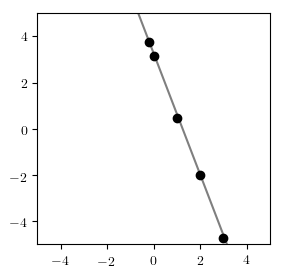

In [16]:
figure(figsize=(3,3))
render_trace(trace);

Because a generative function is stochastic, we need to visualize many runs in order to understand its behavoir. The cell below will allow us to render a grid of traces.

In [17]:
function grid(renderer, traces; ncols=6, nrows=3)
    figure(figsize=(16, 8))
    for (i, trace) in enumerate(traces)
        subplot(nrows, ncols, i)
        renderer(trace)
    end
end;

Now, we generate several traces and render them in a grid

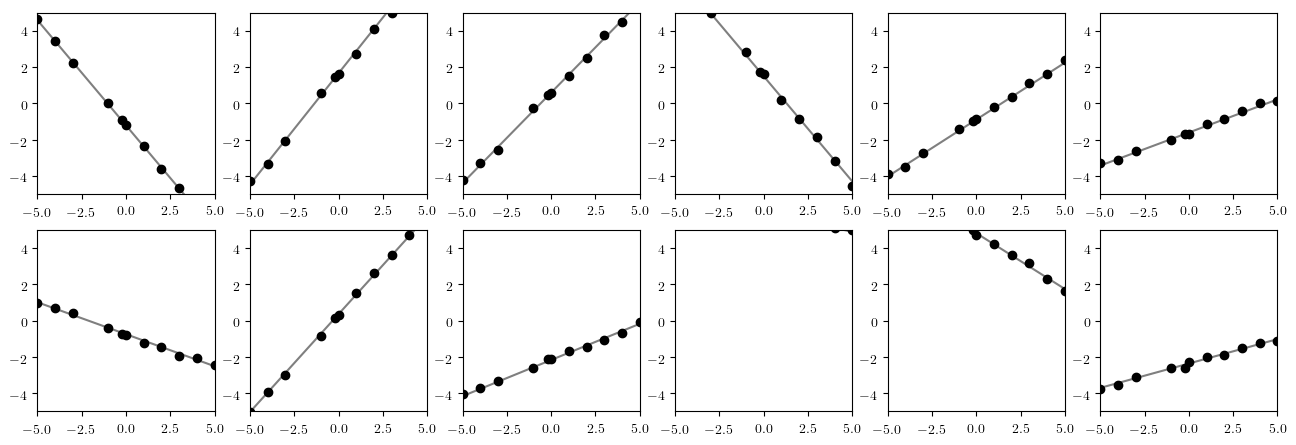

In [18]:
traces = [initialize(line_model, (xs,))[1] for _=1:12]
grid(render_trace, traces)

-------------------------------
### Exercise

Write a model that generates a sine wave of unknown phase, period and amplitude, and then generates y-coordinates from a given vector of x-coordinates by adding noise to the value of the wave at each x-coordinate.
Use a Gamma distribution  (see [`Gen.gamma`](https://probcomp.github.io/Gen/dev/ref/distributions/#Gen.gamma)). for the prior distributions on the period and amplitude, and a uniform distribution for the phase (see [`Gen.uniform`](https://probcomp.github.io/Gen/dev/ref/distributions/#Gen.uniform)). Write a function that renders the trace by showing the data set and the sine wave. Visualize a grid of traces and discuss the distribution. Try tweaking the parameters of each of the prior distributions and seeing how the behavior changes.

Hint: There should be three random choices corresponding to the period, amplitude, and phase, and then N random choices, one for each y-coordinate.

### Solution

In [19]:
@gen function sine_model(xs::Vector{Float64})
    n = length(xs)
    period = @addr(gamma(1, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return n
end;

In [20]:
function render_sine_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    period = assmt[:period]
    amp = assmt[:amp]
    phase = assmt[:phase]
    xmin = minimum(xs)
    xmax = maximum(xs)
    test_xs = collect(range(-5, stop=5, length=100))
    plot(test_xs, amp * sin.(test_xs * (2 * pi / period) .+ phase), color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

In [21]:
traces = [initialize(sine_model, (xs,))[1] for _=1:12];

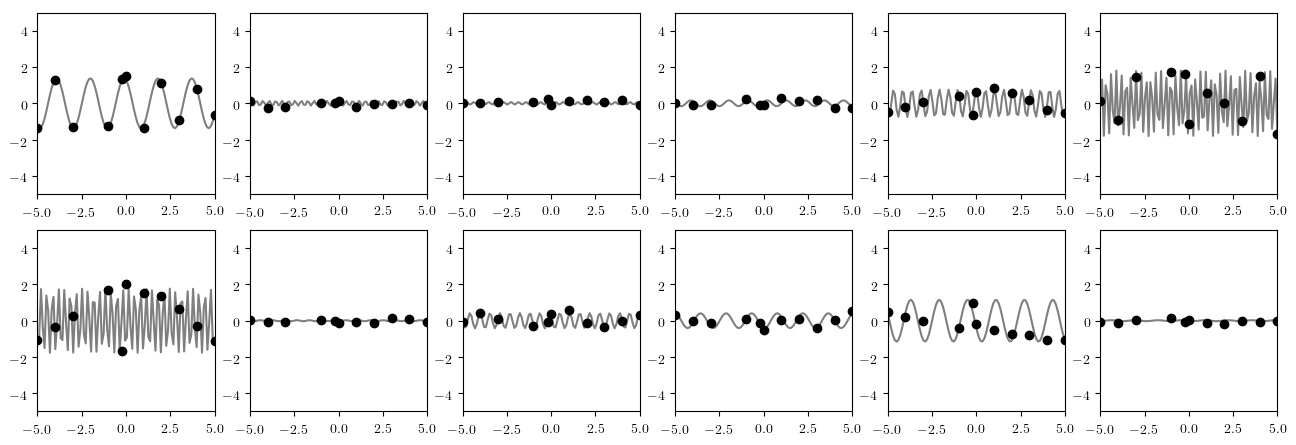

In [22]:
figure(figsize=(16, 8))
for (i, trace) in enumerate(traces)
    subplot(3, 6, i)
    render_sine_trace(trace)
end

## Doing Bayesian inference

We now will provide a data set of y-coordinates and try to draw inferences about the process that generated the data. We begin with the following data set:

In [23]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

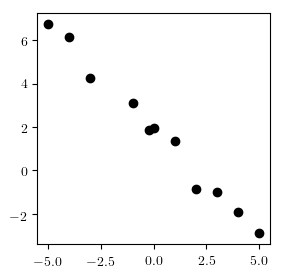

In [24]:
figure(figsize=(3,3))
scatter(xs, ys, color="black");

We will start by assuming that the line model was responsible for generatin the data, and inferring values of the slope and intercept that explain the data.

To do this, we write a simple *inference program* that takes the model we are assuming, the data set, and the amount of computation to perform, and returns a trace of the function that is approximately sampled from the posterior distribution on traces of the function, given the observed data. This inference program is based on a Gen API method `importance_resampling`. Don't worry about the internals of this inference program yet. We will discuss inference programming in later tutorials.

In [25]:
function do_inference(model, xs, ys, amount_of_computation)
    observations = Gen.DynamicAssignment()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

We run the inference program and visualize the result.

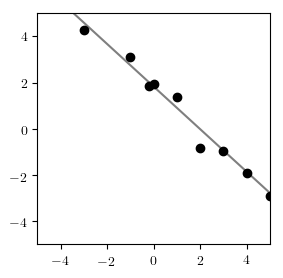

In [26]:
trace = do_inference(line_model, xs, ys, 100)
figure(figsize=(3,3))
render_trace(trace);

We can also visualize many samples in a grid.

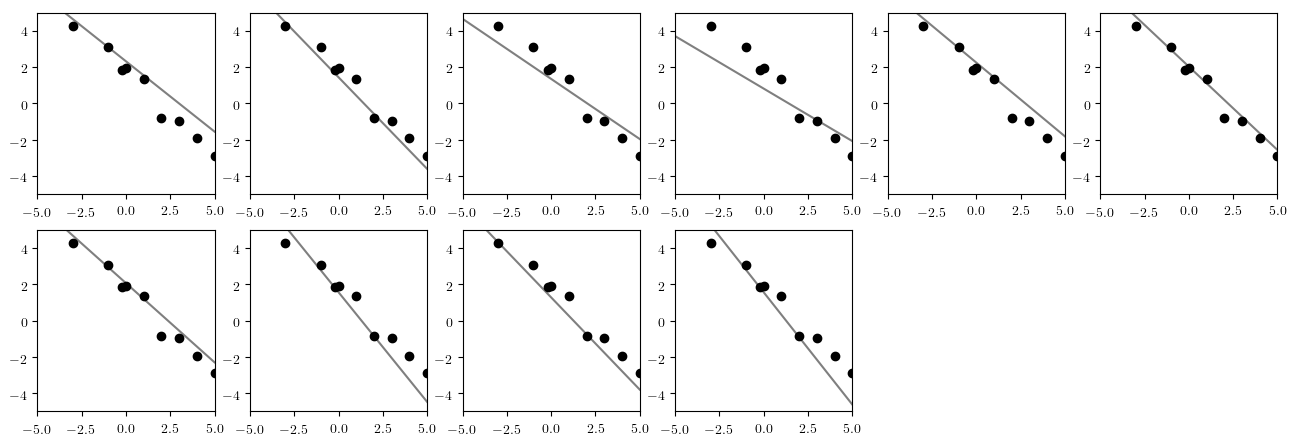

In [27]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
grid(render_trace, traces)

However, in this case we can get a better sense for the variability in the posterior distribution by overlaying the traces. Each trace is going to have the same observed data points, so we only plot those once, based on the values in the first trace.

In [28]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

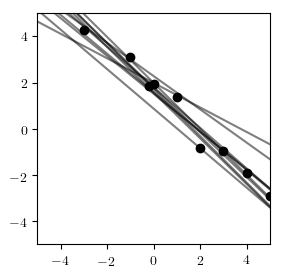

In [29]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
figure(figsize=(3,3))
overlay(render_trace, traces);

--------------

### Exercise

The results above were obtained for `amount_of_computation = 100`. Run the algorithm with this value set to `1`, `10`, and `1000`, etc.  Which value seems like a good tradeoff between accuracy and running time? Discuss.

### Solution

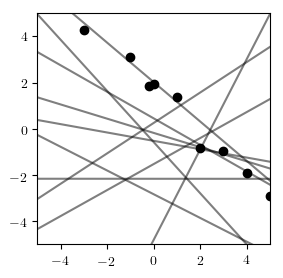

In [30]:
traces = [do_inference(line_model, xs, ys, 1) for _=1:10];
figure(figsize=(3, 3));
overlay(render_trace, traces)

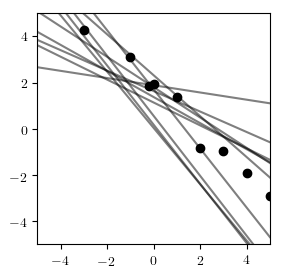

In [31]:
traces = [do_inference(line_model, xs, ys, 10) for _=1:10];
figure(figsize=(3, 3));
overlay(render_trace, traces)

------------------

### Exercise
Consider the following data set.

In [32]:
ys_sine = [2.89, 2.22, -0.612, -0.522, -2.65, -0.133, 2.70, 2.77, 0.425, -2.11, -2.76];

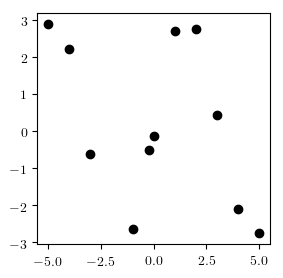

In [33]:
figure(figsize=(3, 3));
scatter(xs, ys_sine, color="black");

Write an inference program that generates traces of the sine wave model that explain this data set. Visualize the resulting distribution of traces. Experiment with a `gamma(1, 1)` and `gamma(5, 1)` prior on the period. Read about the Gamma distribution at https://en.wikipedia.org/wiki/Gamma_distribution. Discuss the results of inference? Do they make sense? How much computation did you need to get good results?

### Solution

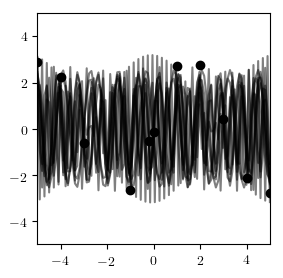

In [34]:
traces = [do_inference(sine_model, xs, ys_sine, 1000) for _=1:10];
figure(figsize=(3,3))
overlay(render_sine_trace, traces)

It is interesting, because any multiple of the "true period" also can explain the data well.

In [35]:
@gen function sine_model_2(xs::Vector{Float64})
    period = @addr(gamma(5, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), 0.1), (:y, i))
    end
    return nothing
end;

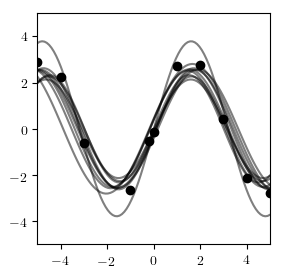

In [36]:
traces = [do_inference(sine_model_2, xs, ys_sine, 1000) for _=1:10];
figure(figsize=(3,3))
overlay(render_sine_trace, traces)

If we reduce the prior probability of very high frequencies, we can get the posterior to concentrate on the "right" period.

## Predicting new data

By providing a third argument to `Gen.initialize`, it is possible to run a generatiev function with the values of certain random choices constrained to given values. The third argument an assignment. For example:

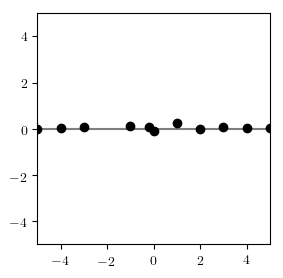

In [37]:
constraints = Gen.DynamicAssignment()
constraints[:slope] = 0.
constraints[:intercept] = 0.
(trace, _) = Gen.initialize(line_model, (xs,), constraints)
figure(figsize=(3,3))
render_trace(trace);

Note that the random choices corresponding to the y-coordinates are still made randomly. Run the cell above a few times to verify this.

We will use the ability to run constrained executions of a generative function to predict the value of the y-coordinates at new x-coordinates by running new executions of the model generative function in which the random choices corresponding to the parameters have been constrained to their inferred values.  We have provided a function below that takes a trace, and a vector of new x-coordinates, and returns a vector of predicted y-coordinates corresponding to the x-coordinates in `new_xs`. We have designed this function to work with multiple models, so the set of parameter addresses is an argument.

In [38]:
function predict_new_data(model, trace, new_xs::Vector{Float64}, param_addrs)
    constraints = Gen.DynamicAssignment()
    assmt = Gen.get_assmt(trace)
    for addr in param_addrs
        if Gen.has_value(assmt, addr)
            constraints[addr] = assmt[addr]
        end
    end
    (new_trace, _) = Gen.initialize(model, (new_xs,), constraints)
    new_assmt = Gen.get_assmt(new_trace)
    ys = [new_assmt[(:y, i)] for i=1:length(new_xs)]
    return ys
end;

The cell below defines a function that first performs inference on an observed data set `(xs, ys)`, and then runs `predict_new_data` to generate predicted y-coordinates. It repeats this process `num_traces` times, and returns a vector of the resulting y-coordinate vectors.

In [39]:
function infer_and_predict(model, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        trace = do_inference(model, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, trace, new_xs, param_addrs))
    end
    pred_ys
end;

Finally, we define a cell that plots the observed data set `(xs, ys)` as red dots, and the predicted data as small black dots.

In [40]:
function plot_predictions(xs, ys, new_xs, pred_ys)
    scatter(xs, ys, color="red")
    for pred_ys_single in pred_ys
        scatter(new_xs, pred_ys_single, color="black", s=1, alpha=0.3)
    end
end;

Recall the original dataset for the line model. The x-coordinates span the interval -5 to 5.

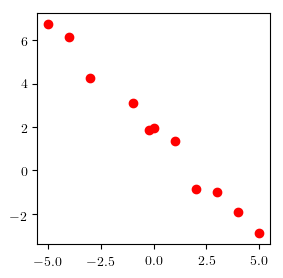

In [41]:
figure(figsize=(3,3))
scatter(xs, ys, color="red");

We will use the inferred values of the parameters to predict y-coordinates for x-coordinates in the interval 5 to 10 from which data was not observed. We will also predict new data within the interval -5 to 5, and we will compare this data to the original observed data. Predicting new data from inferred parameters, and comparing this new data to the observed data is the core idea behind *posterior predictive checking*. This tutorial does not intend to give a rigorous overview behind techniques for checking the quality of a model, but intends to give high-level intuition.

In [42]:
new_xs = collect(range(-5, stop=10, length=100));

We generate and plot the predicted data:

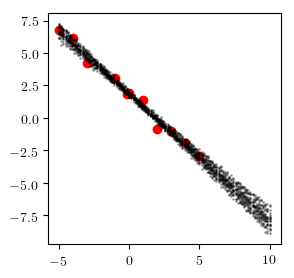

In [43]:
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys, new_xs, pred_ys)

The results look reasonable, both within the interval of observed data and in the extrapolated predictions on the right.

Now consider the same experiment run with following data set, which has significantly more noise.

In [44]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];

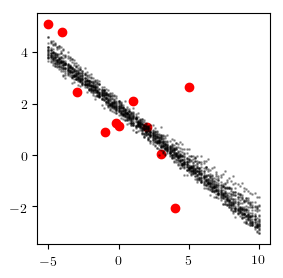

In [45]:
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

It looks like the generated data is less noisy than the observed data in the regime where data was observed, and it looks like the forecasted data is too overconfident. This is a sign that our model is mis-specified. In our case, this is because we have assumed that the noise has value 0.1. However, the actual noise in the data appears to be much larger. We can correct this by making the noise a random choice as well and inferring its value along with the other parameters.

We first write a new version of the line model that samples a random choice for the noise from a `gamma(1, 1)` prior distribution.

In [46]:
@gen function line_model_2(xs::Vector{Float64})
    n = length(xs)
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(slope * x + intercept, noise), (:y, i))
    end
    return nothing
end;

Then, we compare the predictions using inference the unmodified and modified model on the `ys` data set:

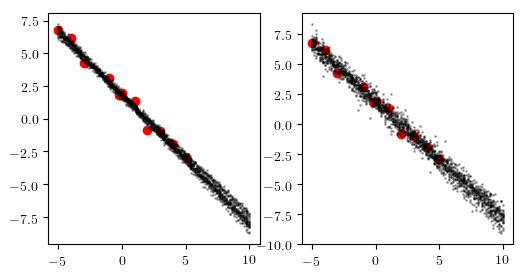

In [47]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
plot_predictions(xs, ys, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(line_model_2, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
plot_predictions(xs, ys, new_xs, pred_ys)

Notice that there is more uncertainty in the predictions made using the modified model.

We also compare the predictions using inference the unmodified and modified model on the `ys_noisy` data set:

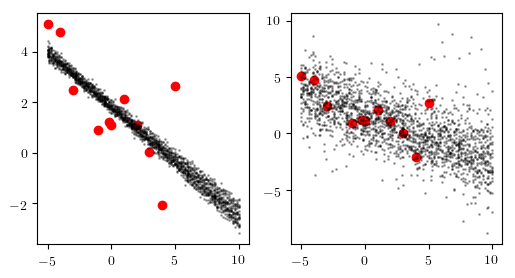

In [48]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(line_model_2, xs, ys_noisy, new_xs, [:slope, :intercept, :noise], 20, 10000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

Notice that while the unmodified model was very overconfident, the modified model has an appropriate level of uncertainty, while still capturing the general negative trend

-------------------------
### Exercise

Write a modified version the sine model that makes noise into a random choice. Compare the predicted data with the observed data `infer_and_predict` and `plot_predictions` for the unmodified and modified model, and for the `ys_sine` and `ys_noisy` datasets. Discuss the results. Experiment with the amount of inference computation used. The amount of inference computation will need to be higher for the model with the noise random choice. We have provided you with starter code.

### Solution

In [49]:
@gen function sine_model_3(xs::Vector{Float64})
    period = @addr(gamma(5, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(amplitude * sin(x * (2 * pi / period) + phase), noise), (:y, i))
    end
    return nothing
end;

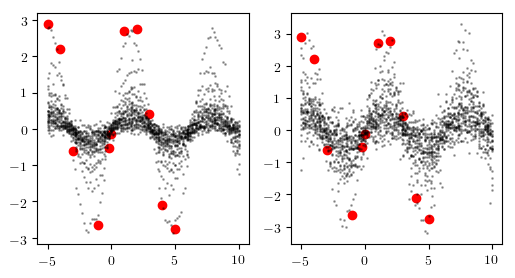

In [50]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(sine_model_2, xs, ys_sine, new_xs, [:period, :amplitude, :phase], 20, 10000)
plot_predictions(xs, ys_sine, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(sine_model_3, xs, ys_sine, new_xs, [:period, :amplitude, :phase, :noise], 20, 50000)
plot_predictions(xs, ys_sine, new_xs, pred_ys)

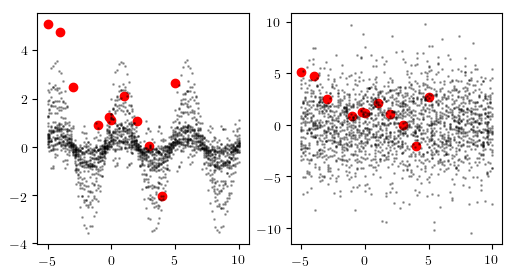

In [51]:
figure(figsize=(6,3))
subplot(1, 2, 1)
pred_ys = infer_and_predict(sine_model_2, xs, ys_noisy, new_xs, [:period, :amplitude, :phase], 20, 10000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)
subplot(1, 2, 2)
pred_ys = infer_and_predict(sine_model_3, xs, ys_noisy, new_xs, [:period, :amplitude, :phase, :noise], 20, 50000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

## Calling other generative functions

In addition to making random choices, generative functions can invoke other generative functions. To illustrate this, we will write a probabilistic model that combines the line model and the sine model. This model is able to explain data using either model, and which model is chosen will depend on the data. This is called *model selection*.

A generative function can invoke another generative function in two ways -- using `@splice` or using `@addr`. When invoking using `@splice`, the random choices of the callee function are placed in the same address namespace as the caller's random choices. When using `@addr(<call>, <addr>)`, the random choices of the callee are placed under the namespace `<addr>`.

In [52]:
@gen function foo()
    @addr(normal(0, 1), :y)
end

@gen function bar_splice()
    @addr(bernoulli(0.5), :x)
    @splice(foo())
end

@gen function bar_addr()
    @addr(bernoulli(0.5), :x)
    @addr(foo(), :z)
end;

We first show the addresses sampled by `bar_splice`:

In [53]:
(trace, ) = initialize(bar_splice, ())
println(get_assmt(trace))

│
├── :y : -0.2362063308378771
│
└── :x : true



And the addresses sampled by `bar_addr`:

In [54]:
(trace, ) = initialize(bar_addr, ())
println(get_assmt(trace))

│
├── :x : false
│
└── :z
    │
    └── :y : 0.10827759243736801



Using `@addr` instead of `@splice` can help avoid address collisions for complex models.

Now, we write a generative function that combies the line and sine models. It makes a Bernoulli random choice (e.g. a coin flip that returns true or false) that determines which of the two models will generate the data.

In [55]:
@gen function combined_model(xs::Vector{Float64})
    if @addr(bernoulli(0.5), :is_line)
        @splice(line_model_2(xs))
    else
        @splice(sine_model_3(xs))
    end
end;

We also write a visualization for a trace of this function:

In [56]:
function render_combined(trace; show_data=true)
    assmt = get_assmt(trace)
    if assmt[:is_line]
        render_trace(trace, show_data=show_data)
    else
        render_sine_trace(trace, show_data=show_data)
    end
end;

We visualize some traces, and see that sometimes it samples linear data and other times sinusoidal data.

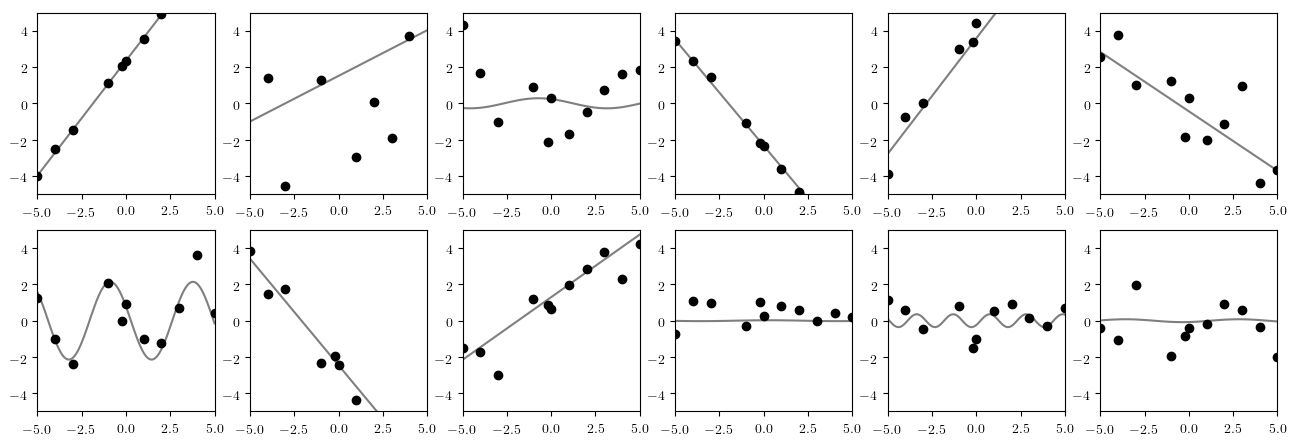

In [57]:
traces = [initialize(combined_model, (xs,))[1] for _=1:12];
grid(render_combined, traces)

We run inference using this combined model on the `ys` data set and the `ys_sine` data set. 

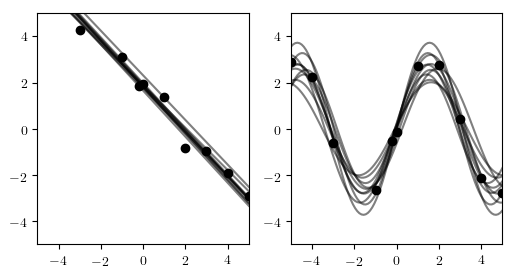

In [91]:
figure(figsize=(6,3))
subplot(1, 2, 1)
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_combined, traces)
subplot(1, 2, 2)
traces = [do_inference(combined_model, xs, ys_sine, 10000) for _=1:10];
overlay(render_combined, traces)

------
### Exercise 

There is code duplication in `line_model_3` and `sine_model_3`. Refactor the model to reduce code duplication and improve the readability of the code. Re-run the experiment above and confirm that the results are qualitatively the same. You may need to write a new rendering function. Try to avoid introducing code duplication between the model and the rendering code.

Hint: To avoid introducing code duplication between the model and the rendering code, use the return value of the generative function.

### Solution

In [92]:
@gen function line_model_refactored()
    slope = @addr(normal(0, 1), :slope)
    intercept = @addr(normal(0, 2), :intercept)
    return (x) -> slope * x + intercept
end;

In [93]:
@gen function sine_model_refactored()
    period = @addr(gamma(5, 1), :period)
    amplitude = @addr(gamma(1, 1), :amp)
    phase = @addr(uniform(0, 2*pi), :phase)
    return (x) -> amplitude * sin(x * (2 * pi / period) + phase)
end;

In [94]:
@gen function combined_model_refactored(xs::Vector{Float64})
    if @addr(bernoulli(0.5), :is_line)
        mean_fn = @splice(line_model_refactored())
    else
        mean_fn = @splice(sine_model_refactored())
    end
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(mean_fn(x), noise), (:y, i))
    end
    return mean_fn;
end;

In [95]:
function render_either_refactored(trace; show_data=true)
    xs = get_args(trace)[1]
    mean_fn = get_retval(trace)
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    xmin = minimum(xs)
    xmax = maximum(xs)
    test_xs = collect(range(-5, stop=5, length=100))
    plot(test_xs, map(mean_fn, test_xs), color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

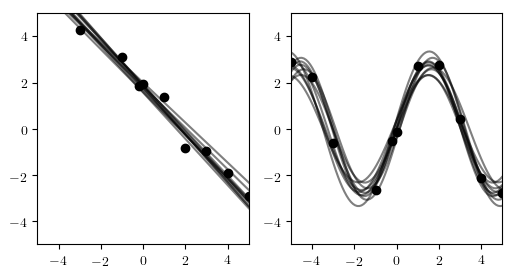

In [96]:
figure(figsize=(6,3))
subplot(1, 2, 1)
traces = [do_inference(combined_model, xs, ys, 10000) for _=1:10];
overlay(render_combined, traces)
subplot(1, 2, 2)
traces = [do_inference(combined_model, xs, ys_sine, 10000) for _=1:10];
overlay(render_combined, traces)

-------

### Exercise

Construct a data set for which it is ambiguous whether the line or sine wave model is best. Visualize the inferred traces usingn `render_either` to illustrate the ambiguity. Write a program that takes the data set and returns an estimate of the posterior probability that the data was generated by the sine wave model, and run it on your data set.

Hint: To estimate the posterior probability that the data was generated by the sine wave model, run the inference program many times to compute a large number of traces, and then compute the fraction of those traces in which `:is_line` is false.

### Solution

In [104]:
ys_ambig = 3 * sin.(0.5 * xs);

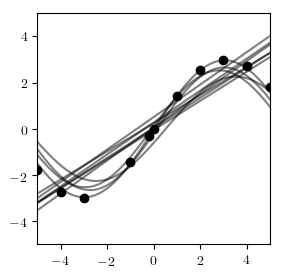

In [105]:
figure(figsize=(3,3))
traces = [do_inference(combined_model, xs, ys_ambig, 10000) for _=1:10];
overlay(render_combined, traces)

In [106]:
function estimate_prob_sine(xs, ys)
    m = 20
    traces = [do_inference(combined_model, xs, ys, 10000) for _=1:m];
    num_sine = sum(map((t) -> !get_assmt(t)[:is_line], traces))
    return num_sine / m
end;

In [108]:
println(estimate_prob_sine(xs, ys_ambig))

0.3


In [109]:
println(estimate_prob_sine(xs, ys))

0.0


In [110]:
println(estimate_prob_sine(xs, ys_sine))

1.0


## Modeling with an infinite discrete hypothesis space

Gen's built-in modeling language can be used to express models that include more complex explanations for data that from hypothesis spaces that include an infinite set of possible discrete combinatorial structures. This section walks you through development of a model of data that does not a-priori specify an upper bound on the complexity model, but instead infers the complexity of the model as well as the parameters. This is a simple example of a *Bayesian nonparametric* model.

We will consider two data sets:

In [140]:
xs_dense = collect(range(-5, stop=5, length=50))
ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;

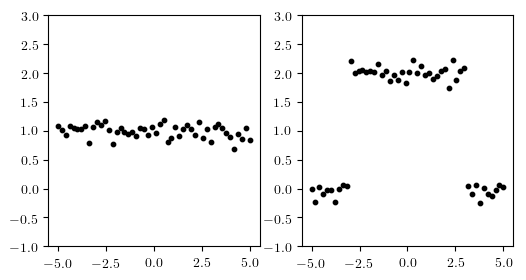

In [141]:
figure(figsize=(6,3))
subplot(1, 2, 1)
scatter(xs_dense, ys_simple, color="black", s=10)
gca()[:set_ylim]((-1, 3))
subplot(1, 2, 2)
scatter(xs_dense, ys_complex, color="black", s=10);
gca()[:set_ylim]((-1, 3));

The data set on the left appears to be best explained as a contant function with some noise. The data set on the right appears to include four changepoints, with a constant function in between the changepoints. We want a model that does not a-priori choose the number of changepoints in the data. To do this, we will recursively partition the interval into regions.

In [116]:
struct Interval
    l::Float64
    u::Float64
end

In [117]:
abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

In [122]:
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if @addr(bernoulli(0.7), :isleaf)
        value = @addr(normal(0, 1), :value)
        return LeafNode(value, interval)
    else
        frac = @addr(beta(2, 2), :frac)
        mid  = l + (u - l) * frac
        left = @addr(generate_segments(l, mid), :left)
        right = @addr(generate_segments(mid, u), :right)
        return InternalNode(left, right, interval)
    end
end;

In [123]:
function render_node(node::LeafNode)
    plot([node.interval.l, node.interval.u], [node.value, node.value])
end

function render_node(node::InternalNode)
    render_node(node.left)
    render_node(node.right)
end;

In [124]:
function render_segments_trace(trace)
    node = get_retval(trace)
    render_node(node)
    ax = gca()
    ax[:set_xlim]((0, 1))
    ax[:set_ylim]((-3, 3))
end;

We generate 12 traces from this function and visualize them below.

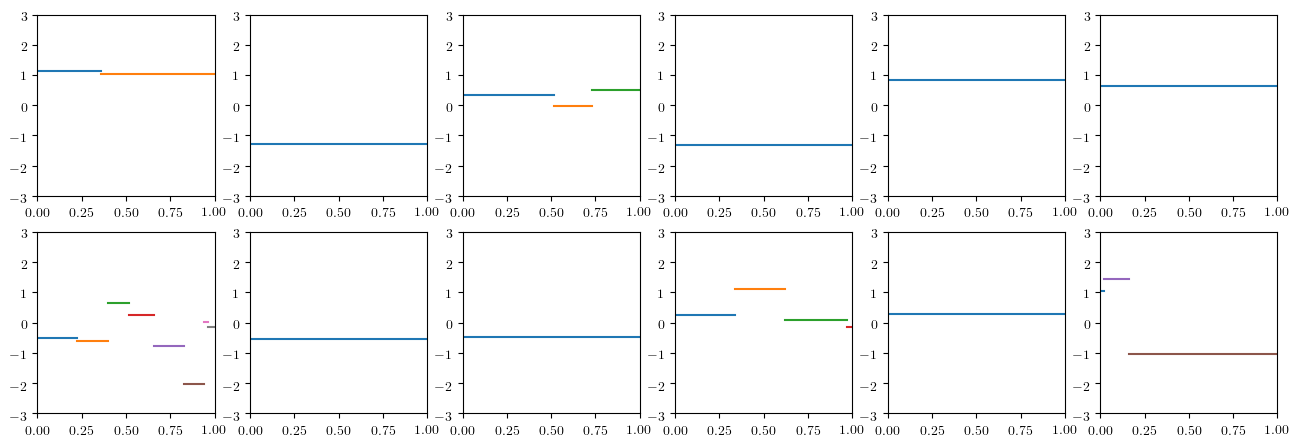

In [125]:
traces = [initialize(generate_segments, (0., 1.))[1] for i=1:12]
grid(render_segments_trace, traces)

Now that we have generative function that generates an unknown partition into segments with values, we write a model that adds noise to the resulting constant functions to generate a data set of y-coordinates. The noise level will be a random choice.

In [126]:
function get_value_at(x::Float64, node::LeafNode)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value
end

function get_value_at(x::Float64, node::InternalNode)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

@gen function changepoint_model(xs::Vector{Float64})
    node = @addr(generate_segments(minimum(xs), maximum(xs)), :tree)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(get_value_at(x, node), noise), (:y, i))
    end
    return node
end;

We write a visualization for `changepoint_model` below:

In [127]:
function render_cp_model_trace(trace; show_data=true)
    xs = get_args(trace)[1]
    node = get_retval(trace)
    render_node(node)
    assmt = get_assmt(trace)
    if show_data
        ys = [assmt[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    ax = gca()
    ax[:set_xlim]((minimum(xs), maximum(xs)))
    ax[:set_ylim]((-3, 3))
end;

Finally, we generate some simulated data sets and visualize them on top of the underlying piecewise constant function from which they were generated:

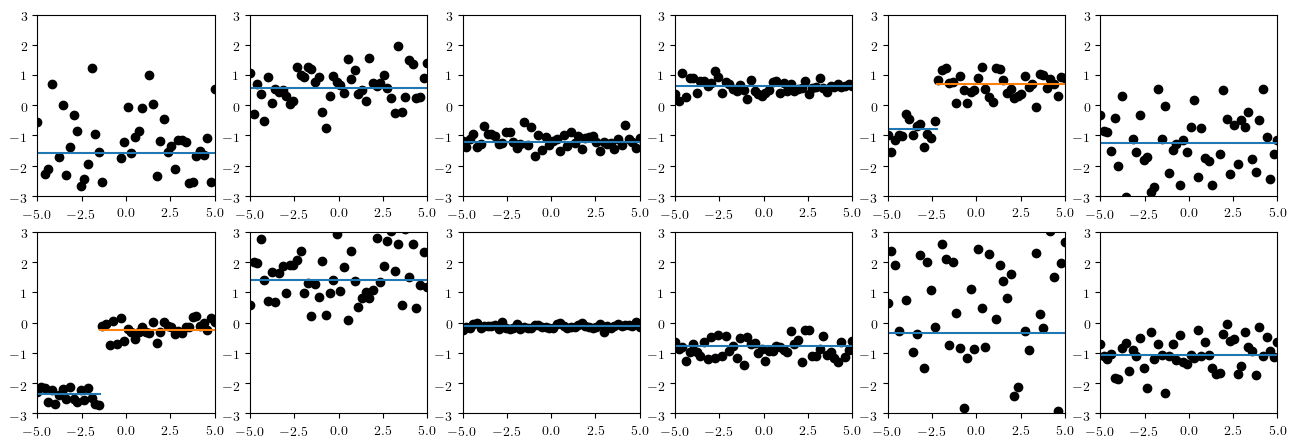

In [136]:
traces = [initialize(changepoint_model, (xs_dense,))[1] for i=1:12]
grid(render_cp_model_trace, traces)

Now we perform inference on the simple data set:

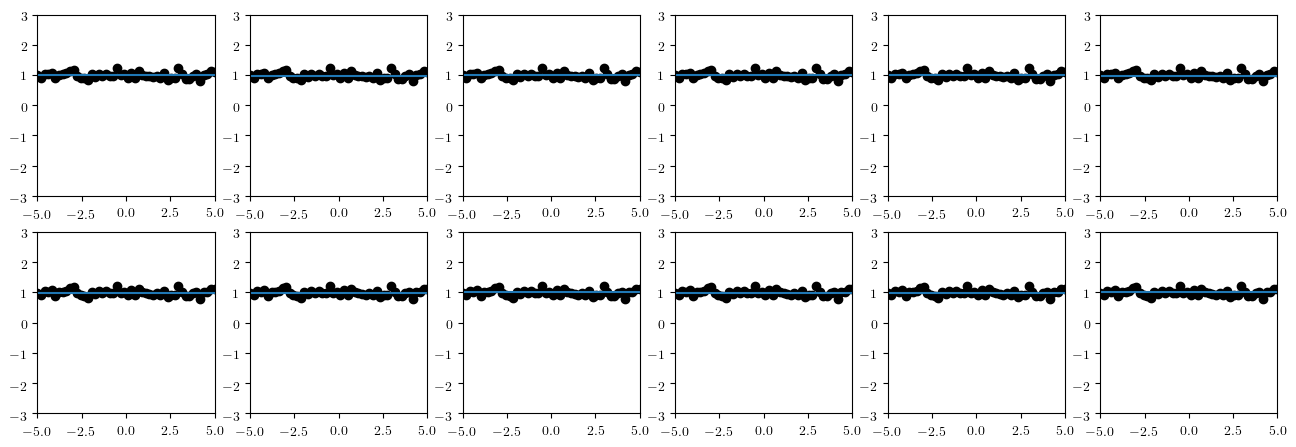

In [137]:
traces = [do_inference(changepoint_model, xs_dense, ys_simple, 10000) for _=1:12];
grid(render_cp_model_trace, traces)

And the more complex data set:

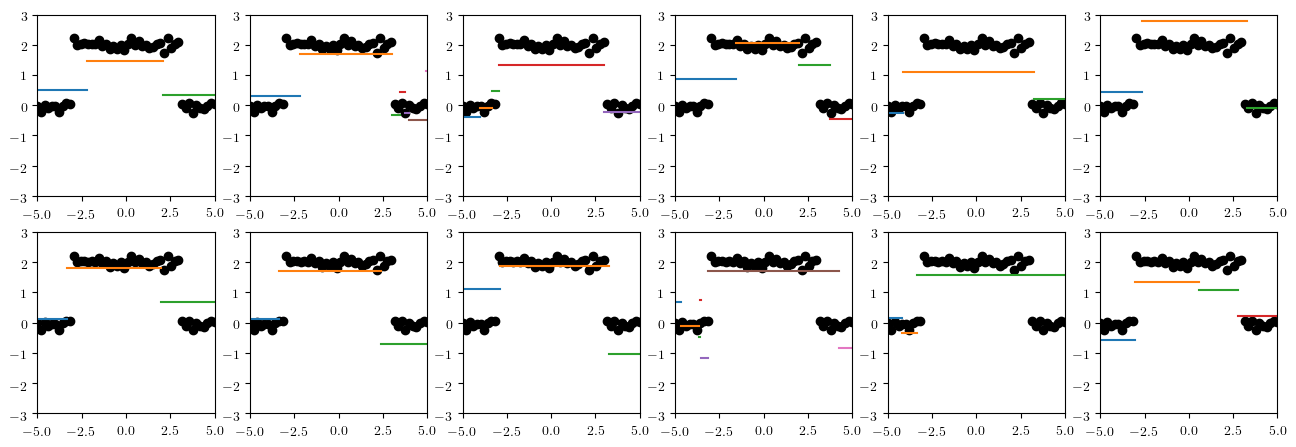

In [142]:
traces = [do_inference(changepoint_model, xs_dense, ys_complex, 10000) for _=1:12];
grid(render_cp_model_trace, traces)

------
### Exercise
Write a function that plots the histogram of the probability distribution on the number of changepoints.
Show the results for the `ys_simple` and `ys_complex` data sets.

-------

### Exercise
Write a new version of `changepoint_model` that uses `@splice` to make the recursive calls instead of `@addr`.

Hint: Recall that addresses can be arbitrary values, not just symbols.

### Solution

In [147]:
@gen function generate_segments_splice(idx::Int, l::Float64, u::Float64)
    interval = Interval(l, u)
    if @addr(bernoulli(0.7), (idx, :isleaf))
        value = @addr(normal(0, 1), (idx, :value))
        return LeafNode(value, interval)
    else
        frac = @addr(beta(2, 2), (idx, :frac))
        mid  = l + (u - l) * frac
        left = @splice(generate_segments_splice(idx * 2, l, mid))
        right = @splice(generate_segments_splice(idx * 2 + 1, mid, u))
        return InternalNode(left, right, interval)
    end
end;

@gen function changepoint_model_splice(xs::Vector{Float64})
    node = @addr(generate_segments_splice(1, minimum(xs), maximum(xs)), :tree)
    noise = @addr(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @addr(normal(get_value_at(x, node), noise), (:y, i))
    end
    return node
end;

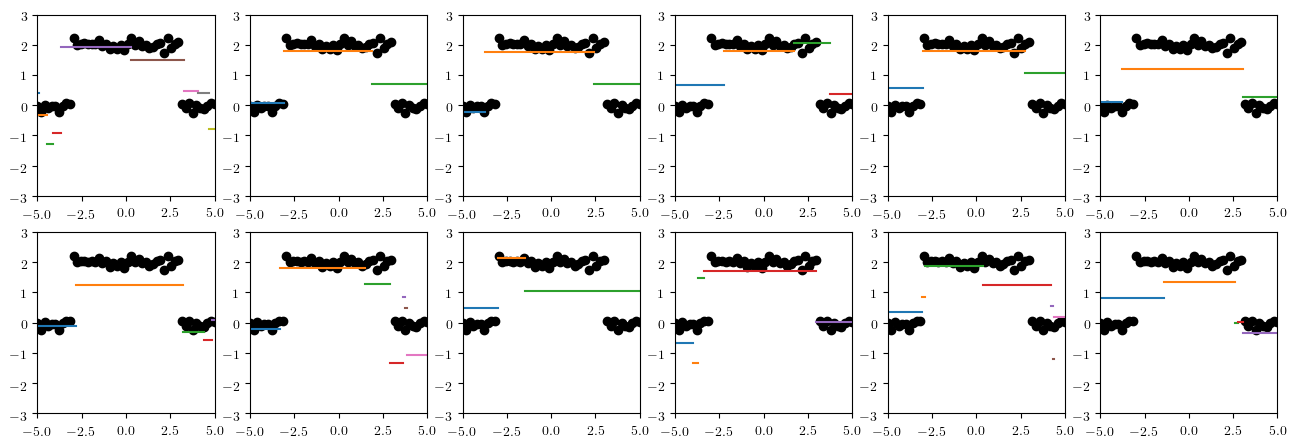

In [148]:
traces = [do_inference(changepoint_model_splice, xs_dense, ys_complex, 10000) for _=1:12];
grid(render_cp_model_trace, traces)

## Modeling with black box code

In this section we will implement an inference program that infers the probable destination of an autonomous agent from its observed motion in a two-dimensional environment with obstacles. The model witll include (i) a prior distribution on the destination of the agent, and (ii) an algorithmic model for how the agent plans its movement based on its destination, (iii) a statistical model of the noise in our measurements of the agent's motion. This model illustrates that arbitrary code (in this case, the planning algorithm) and custom data types can be included in Gen models.

First, we have provided some of the basic geometric primitives in the following file:

In [149]:
include("geometric_primitives.jl");

This file defines two-dimensional `Point` data type with fields `x` and `y`:

In [153]:
point = Point(1.0, 2.0)
println(point.x)
println(point.y)

1.0
2.0


The file defines a method that computes the distance between two points: 

In [154]:
dist(Point(1.0, 1.0), Point(0.0, 0.0))

1.4142135623730951

The file also defines an `Obstacle` data type, which represents a polygonal obstacle in a two-dimensional scene, that is constructed from a list of vertices. Here, we construct a square:

In [155]:
obstacle = Obstacle([Point(0.0, 0.0), Point(1.0, 0.0), Point(0.0, 1.0), Point(1.0, 1.0)]);

The file also defines a method to test whether an obstacle intersects with a line segment, which is defined by a start point and an end point:

In [160]:
println(obstacle_intersects_line_segment(obstacle, Point(-1.0, 0.5), Point(2.0, 0.5)))

true


In [161]:
println(obstacle_intersects_line_segment(obstacle, Point(-1.0, 1.5), Point(2.0, 1.5)))

false


Given these geometric primitives, we define a data type to represent the two-dimensional scene. The scene spans a rectangle of on the two-dimensional x-y plane, and contains a list of obstacles. Each obstacle is a polygon defined by a list of vertex points. We also define a method to compute whether a given line is obstructed by any obstacles in the scene.

In [163]:
struct Scene
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
    obstacles::Vector{Obstacle}
end

Scene(xmin, xmax, ymin, ymax) = Scene(xmin, xmax, ymin, ymax, Obstacle[])

add_obstacle!(scene, obstacle::Obstacle) = push!(scene.obstacles, obstacle)

function line_is_obstructed(scene::Scene, a1::Point, a2::Point)
    for obstacle in scene.obstacles
        if obstacle_intersects_line_segment(obstacle, a1, a2)
            return true
        end
    end
    false
end;

Finally, we write some methods that allow us to concisely construct walls (line-shaped obstacles that are either vertically or horizontally oriented), and square-shaped obstacles (representing trees).

In [165]:
function make_wall(vertical::Bool, start::Point, length::Float64, thickness::Float64)
    vertices = Vector{Point}(undef, 4)
    vertices[1] = start
    dx = vertical ? thickness : length
    dy = vertical ? length : thickness
    vertices[2] = Point(start.x + dx, start.y)
    vertices[3] = Point(start.x + dx, start.y + dy) 
    vertices[4] = Point(start.x, start.y + dy)
    Obstacle(vertices)
end 

function make_tree(center::Point, size::Float64)
    vertices = Vector{Point}(undef, 4)
    vertices[1] = Point(center.x - size/2, center.y - size/2)
    vertices[2] = Point(center.x + size/2, center.y - size/2)
    vertices[3] = Point(center.x + size/2, center.y + size/2)
    vertices[4] = Point(center.x - size/2, center.y + size/2)
    Obstacle(vertices)
end;

We now construct a scene value that we will use in the rest of the tutorial:

In [168]:
scene = Scene(0, 1, 0, 1)
add_obstacle!(scene, make_tree(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_tree(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_tree(Point(0.80, 0.40), 0.1))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_wall(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_wall(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_wall(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_wall(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_wall(vertical, Point(0.20, 0.40), 0.40, wall_thickness));

We visualize the scene below, using a custom visualization written using [GenViz](https://github.com/probcomp/GenViz).

To use GenViz, we first start a GenViz server:

In [166]:
using GenViz
server = VizServer(8000)
sleep(1)

In [ ]:
info = Dict("scene" => scene)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

Next, we implement a simple planning algorithm based on the rapidly exploring random tree (RRT) algorithm [2]. The planning algorithm will take as input (i) the scene, (ii) the start point, and (iii) the destination point, and will produce a sequence of points that starts with the start point and ends with the destination point, such the line of sight between each consecutive point does not intersect any obstacles, or return failure if no path could be found.

[2] Rapidly-exploring random trees: A new tool for path planning. S. M. LaValle. TR 98-11, Computer Science Dept., Iowa State University, October 1998,

We load an implementation of the RRT algorithm from the following file:

In [170]:
include("rrt.jl");

The file defines a method `generate_rrt` that takes a scene, a starting point, and algorithm parameters, and returns an `RRT` value, which represents a tree rooted at the starting point that fills the scene.

In [ ]:
start = Point(0.1, 0.1)
tree = generate_rrt(scene, start, 300, 3.0);

In [ ]:
We visualize the resulting tree on top of the scene:

In [ ]:
info = Dict("start"=> start, "scene" => scene, "tree_edges" => get_edges(tree))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

Given a RRT, and a destination point, we can find a path from the root of the RRT to the destination point, by finding a node on the tree that has a clear line-of-sight to the destination node, and is also as close as possible to the destination node. We then walk back from this node along the edges of the tree to the route to construct the path. If there is no node on the tree with a clear line-of-sight to the destination, we return the value `nothing`:

In [ ]:
struct Path
    points::Vector{Point}
end

function get_path_to_dest(tree::RRT, destination::Point)
    
    # find a node in the tree with a clear line-of-sight to the destination
    best_node = tree.nodes[1]
    min_cost = Inf
    path_found = false
    for node in tree.nodes
        clear_path = !line_is_obstructed(scene, node.conf, destination)
        cost = node.dist_from_start + (clear_path ? dist(node.conf, destination) : Inf)
        if cost < min_cost
            path_found = true
            best_node = node
            min_cost = cost
        end
    end
    
    if path_found
        
        # walk from the best node to the root of the tree to construct the path
        points = Point[destination]
        node = best_node
        while node.parent != nothing
            push!(points, node.conf)
            node = node.parent
        end
        push!(points, root(tree).conf)
        Path(reverse(points))
    else
        
        # return nothing if no path was found
        nothing
    end
end

We visualize an example path below:

In [ ]:
function get_edges(path::Path)
    edges = Tuple{Point,Point}[]
    for i=1:length(path.points)-1
        push!(edges, (path.points[i], path.points[i+1]))
    end
    edges
end

In [ ]:
dest = Point(0.5, 0.5)
path = get_path_to_dest(tree, dest)

In [ ]:
info = Dict("start"=> start, "dest" => dest, "scene" => scene,
    "tree_edges" => get_edges(tree), "path_edges" => get_edges(path))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

The paths along the tree that are generated by the RRT algorithm are generally not very direct. We want our agent to take fairly direct paths from its starting location to the destination. Therefore, we use the following path-refinement procedure to optimize the path points to shorten the length of the path while still avoiding obstruction by obstacles. You don't need to worry about the details of this procedure.

In [ ]:
function refine_path(scene::Scene, original::Path, iters::Int, std::Float64)
    new_points = copy(original.points)
    num_interior_points = length(original.points) -2
    if num_interior_points == 0
        return original
    end
    for i=1:iters
        
        # propose an adjustment to one of the interior points on the path (not the first or last point)
        point_idx = 2 + (i % num_interior_points)
        prev_point = new_points[point_idx-1]
        point = new_points[point_idx]
        next_point = new_points[point_idx+1]
        adjusted_point = Point(point.x + randn() * std, point.y + randn() * std)
        
        # check if the new path is obstructed by obstacles
        ok_backward = !line_is_obstructed(scene, prev_point, adjusted_point)
        ok_forward = !line_is_obstructed(scene, adjusted_point, next_point)
        
        # accept the adjustment if it is not obstructed by obstacles and it reduces the length of the path
        if ok_backward && ok_forward
            new_dist = dist(prev_point, adjusted_point) + dist(adjusted_point, next_point)
            cur_dist = dist(prev_point, point) + dist(point, next_point)
            if new_dist < cur_dist
                new_points[point_idx] = adjusted_point
            end
        end
    end
    Path(new_points)
end

In [ ]:
path = refine_path(scene, path, 2000, 1.)
info = Dict("start"=> start, "dest" => dest, "scene" => scene,
    "tree_edges" => get_edges(tree), "path_edges" => get_edges(path))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

Finally, we combine each of the steps we just defined into a path-planning function. If a path could not be found, we return the value `nothing`. Otherwise, we return a `Path` value The path-planning function has parameters for how to grow the RRT (`rrt_iters` and `rrt_dt`) and how to perform the refinement (`refine_iters` and `refine_std`).

In [ ]:
struct PlannerParams
    rrt_iters::Int
    rrt_dt::Float64
    refine_iters::Int
    refine_std::Float64
end

function plan_path(start::Point, dest::Point, scene::Scene, params::PlannerParams)
    
    # Generate a rapidly exploring random tree
    tree = generate_rrt(scene, start, params.rrt_iters, params.rrt_dt)

    # Find a route from the root of the tree to a node on the tree that has a line-of-sight to the destination
    maybe_path = get_path_to_dest(tree, dest)
    
    if maybe_path == nothing
        
        # No route found
        return (nothing, tree)
    else
        
        # Route found
        path = something(maybe_path)
        refined_path = refine_path(scene, maybe_path, params.refine_iters, params.refine_std)
        return (refined_path, tree)
    end
end



We can now run the end-to-end path planning procedure. Run the cell below a few times to get a sense for the variability in the path planner.

In [ ]:
(path, tree) = plan_path(start, dest, scene, PlannerParams(300, 3.0, 2000, 1.))
info = Dict("start"=> start, "dest" => dest, "scene" => scene,
    "tree_edges" => get_edges(tree), "path_edges" => get_edges(path))
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

We also need a model for how the agent moves along its path.
We will assume that the agent moves along its path a constant speed. The cell below defines a method that computes the locations of the agent at a set of timepoints, given the path and the speed of the agent. You don't need to worry about the details of this cell.

In [171]:
function compute_distances_from_start(path::Path)
    distances_from_start = Vector{Float64}(undef, length(path.points))
    distances_from_start[1] = 0.0
    for i=2:length(path.points)
        distances_from_start[i] = distances_from_start[i-1] + dist(path.points[i-1], path.points[i])
    end
    return distances_from_start
end

function walk_path(path::Path, speed::Float64, dt::Float64, num_ticks::Int)
    distances_from_start = compute_distances_from_start(path)
    locations = Vector{Point}(undef, num_ticks)
    locations[1] = path.points[1]
    t = 0.
    for time_idx=1:num_ticks
        desired_distance = t * speed
        used_up_time = false
        # NOTE: can be improved (iterate through path points along with times)
        for i=2:length(path.points)
            prev = path.points[i-1]
            cur = path.points[i]
            dist_to_prev = dist(prev, cur)
            if distances_from_start[i] >= desired_distance
                # we overshot, the location is between i-1 and i
                overshoot = distances_from_start[i] - desired_distance
                @assert overshoot <= dist_to_prev
                past_prev = dist_to_prev - overshoot
                frac = past_prev / dist_to_prev
                locations[time_idx] = Point(prev.x * (1. - frac) + cur.x * frac,
                                     prev.y * (1. - frac) + cur.y * frac)
                used_up_time = true
                break
            end
        end
        if !used_up_time
            # sit at the goal indefinitely
            locations[time_idx] = path.points[end]
        end
        t += dt
    end
    locations
end

UndefVarError: UndefVarError: Path not defined

We now can write a generative function that models the behavior of an autonomous agent.

In [ ]:
@gen function model(scene::Scene, dt::Float64, num_ticks::Int)

    # sample the start point of the agent from the prior
    start_x = @addr(uniform(0, 1), :start_x)
    start_y = @addr(uniform(0, 1), :start_y)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x = @addr(uniform(0, 1), :dest_x)
    dest_y = @addr(uniform(0, 1), :dest_y)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    (maybe_path, _) = plan_path(start, dest, scene, PlannerParams(300, 3.0, 2000, 1.))
    
    # sample the speed from the prior
    speed = @addr(uniform(0, 1), :speed)

    if maybe_path == nothing
        
        # path planning failed, assume the agent stays as the start location indefinitely
        locations = fill(start, num_ticks)
    else
        
        # path planning succeeded, move along the path at constant speed
        path = something(maybe_path)
        locations = walk_path(path, speed, dt, num_ticks)
    end

    # generate noisy measurements
    noise = 0.01
    measurements = Vector{Point}(undef, num_ticks)
    for (i, point) in enumerate(locations)
        x = @addr(normal(point.x, noise), :meas => i => :x)
        y = @addr(normal(point.y, noise), :meas => i => :y)
        measurements[i] = Point(x, y)
    end

    (start, dest, speed, noise, maybe_path, locations, measurements)
end

We will use a time step of `dt = 0.1` and we will assume that 10 measurements are taken:

In [172]:
const dt = 0.1
const num_ticks = 10;

We can now perform traced executions the generative function using Gen's `initialize` method. Here, we obtain a traced execution, then obtain the assignment to random choices made during the execution, and print it.

In [ ]:
(trace, _) = initialize(model, (scene, dt, num_ticks));
assmt = get_assmt(trace)
println(assmt)

Here we explore the assumptions of the model by sampling many traces from the generative function and visualizing them. We have created a visualization specialized for this generative function for use with the `GenViz` package, in the directory `grid-viz/dist`. We have also defined a `trace_to_dict` method to convert the trace into a value that can be easily serialized into a JSON string:

In [ ]:
function trace_to_dict(trace)
    args = get_args(trace)
    (scene, dt, num_ticks) = args

    retval = get_retval(trace)
    (start, dest, speed, noise, maybe_path, locations, measurements) = retval

    d = Dict()

    # scene (the obstacles)
    d["scene"] = scene

    # the path
    if maybe_path != nothing
        d["path"] = maybe_path.points
    else
        d["path"] = []
    end

    # start and destination location
    d["start"] = start
    d["dest"] = dest

    # observed points
    d["measurements"] = measurements

    d
end

In [ ]:
import Random
Random.seed!(3);

In [ ]:
viz = Viz(server, joinpath(@__DIR__, "grid-viz/dist"), [])
constraints = DynamicAssignment()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1
for i=1:12
    (trace, _) = initialize(model, (scene, dt, num_ticks), constraints)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

In this visualziation, the start location is represented by a blue dot, and the destination is represented by a red dot. The measured coordinates at each time point are represented by black dots. The path, if path planning was succesfull, is shown as a gray line fro the start point to the destination point. Notice that the speed of the agent is different in each case.

We now write a simple algorithm for inferring the destination of an agent given (i) the scene, (ii) the start location of the agent, and (iii) a sequence of measured locations of the agent for each tick.

In [ ]:
start = Point(0.1, 0.1)

measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

In [ ]:
We visualize the data set:

In [ ]:
(path, tree) = plan_path(start, dest, scene, PlannerParams(300, 3.0, 2000, 1.))
info = Dict("start" => start, "scene" => scene, "measurements" => measurements)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
displayInNotebook(viz)

In [ ]:
function do_inference(scene::Scene, dt::Float64, num_ticks::Int, start::Point,
                      measurements::Vector{Point}, num_particles::Int)
    
    # construct observations assignment
    observations = DynamicAssignment()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => i => :x] = m.x
        observations[:meas => i => :y] = m.y
    end
    
    # use importance sampling with resampling to obtain an inferred trace
    (trace, _) = importance_resampling(model, (scene, dt, num_ticks), observations, num_particles)
    
    trace
end


Below, we run this algorithm 1000 times, using 50 particles for each run, and visualize the inferred destinations. The inferred destinations should appear as red dots on the map.

In [ ]:
info = Dict("measurements" => measurements, "scene" => scene, "start" => start)
viz = Viz(server, joinpath(@__DIR__, "overlay-viz/dist"), info)
openInNotebook(viz)
sleep(5)
for i=1:1000
    trace = do_inference(scene, dt, num_ticks, start, measurements, 50)
    putTrace!(viz, i, trace_to_dict(trace))
end
displayInNotebook(viz)

-------
### Exercise

Write an inference program that infers both the agent's destination and whether or not the walled square is present in the scene or not. Show resut